# Solving an inverse Problem with TorchPhysics and PINNs: Bonus Exercise 8b
Assume you are jumping from a plane with a parachute. Under some simplifications, your fall can be described by the following ODE:
\begin{align*}
    \begin{split}
        \partial_t^2 u(t) &= {\color{red}{D(t)}} \Big[\partial_t u(t)\Big]^2 - g  \text{ for } t\in I_t=[0,T], \\
        u(0) &= H, \\
        \partial_t u(0) &= v_0,
    \end{split}
\end{align*}
where $u : [0, T] \to \mathbb{R}$ is the height at time $t$, $H$ the starting height, $g$ the gravity constant, $v_0$ the initial velocity, and $\color{red}{D(t)}$ a friction coefficient that is proportional to the cross section of the parachute at time $t$.

Given a noisy dataset $\{(u_i, t_i)\}_{i=1}^N$ of the height $u_i$ at time $t_i$, we aim to reconstruct the movement of the parachute described by $\color{red}{D(t)}$.

Again, we use a data condition for learning $u$ from the data. Moreover, since ${\color{red}{D(t)}}$ is only present in the PDE condition, we do not include the remaining conditions for additional loss terms. In other words, we train networks for $u$ and ${\color{red}{D}}$ that minimize
$$
\frac{1}{N}\sum_{i=1}^N \vert u(t_i) - u_i \vert^2 + \frac{1}{M}\sum_{k=1}^M \left\vert \partial_t^2 u(\tilde{t}_k) - {\color{red}{D(\tilde{t}_k)}} \Big[\partial_t u(\tilde{t}_k)\Big]^2 + g \right\vert^2.
$$

In [ ]:
# This block is for GPU selection. Please execute.
import pathlib
import os
user = int(str(pathlib.Path().resolve())[22:24])
if user <= 21: 
    gpu_device = str(user % 7) # moriarty
else: gpu_device = str(user % 4) # neptuno
os.environ["CUDA_VISIBLE_DEVICES"]= gpu_device

In [15]:
import torchphysics as tp
import pytorch_lightning as pl
import torch
import math
from matplotlib import pyplot as plt

# Here all parameters are defined:
g = 9.81                # Gravity constant
H = 0                   # Initial height H
v_0 = -2                # Initial velocity v_0
t_min, t_max = 0.0, 10 # Bounds for time interval

# The groundtruth D(t) that is to be learned
def D_groundtruth(t):
    return 3 * (1.1 + torch.sin(-0.42*t))

### Spaces, domains and samplers

In [3]:
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')
# TODO: Create the output space of parameter function D
D = ...

# TODO: Define the time interval I_t
I_t = ...

# TODO: Create random uniform sampler for the PDE condition, which should hold on I_t. 
#       Use 3000 as the number of sampling points.
pde_sampler = ...

### Load PyTorch dataset $\{(u_i, t_i)\}_{i=1}^N$. 

In [ ]:
t_data = torch.load('../SolutionData/Ex_8b/parachute_t_data.pt')
u_data = torch.load('../SolutionData/Ex_8b/parachute_u_data.pt')

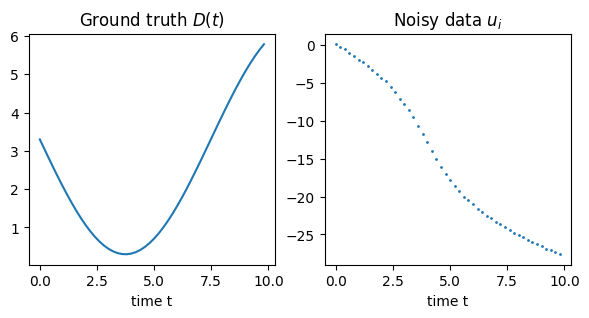

In [5]:
# Plot ground truth parameter D(t) and data u_i
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))
ax1.plot(t_data[:, 0], D_groundtruth(t_data[:, 0]))
ax1.set_title(r'Ground truth $D(t)$')
ax1.set_xlabel('time t')
ax2.scatter(t_data[:, 0], u_data[:, 0], s=1.)
ax2.set_title(r'Noisy data $u_i$')
ax2.set_xlabel('time t')
plt.show()

In [ ]:
# TODO: In order to work with the data in TorchPhysics,
#       we need to transform the data into `tp.spaces.Points` objects.
t_data_points = ...
u_data_points = ...

# TODO: Create a DataLoader, that loads combinations of t_data_points and u_data_points.
# Hint: This is analogous to Exercise_8.
data_loader = tp.utils.PointsDataLoader(..., batch_size=len(t_data))

### Proceed with familiar TorchPhysics pipeline: Create models, residual functions and conditions

In [ ]:
# We use the same model archiecture for u as in Exercise 8
model_u = tp.models.FCN(input_space=T, output_space=U, hidden = (50, 50))

# TODO: Create a FCN for the parameter function D(t). Use hidden=(30, 30, 30)
model_D = ...

# TODO: We want to train the model for u and for D in parallel. For that, pass them as inputs to tp.models.Parallel
model = ...

In [ ]:
# TODO: Create a residual for the PDE condition
def pde_residual(...):
  return ...

# TODO: Create corresponding TorchPhysics condition. 
#       Note that the parallel model for u and D should be trained on this condition.
pde_condition = ...

In [ ]:
# TODO: Again, we need a data condition, which is analogous to Exercise 8.
data_condition = tp.conditions.DataCondition(module=...,
                                             dataloader=...,
                                             norm=2,
                                             use_full_dataset=True,
                                             weight=50)

### Training with the Adam optimizer

In [ ]:
# Training parameters for ADAM optimizer
train_iterations = 5000
learning_rate = 1.e-3

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate)
solver = tp.solver.Solver(train_conditions=[data_condition, pde_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu", # use one GPU
                     max_steps=train_iterations, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=False, # for writting into tensorboard
                     enable_checkpointing=False)

trainer.fit(solver)

In [ ]:
# We plot the parameter function D that we learned
from matplotlib import pyplot as plt

plot_domain = tp.domains.Interval(T, t_min, t_max)
plot_sampler = tp.samplers.PlotSampler(plot_domain, 1000)
fig = tp.utils.plot(model_D, lambda D: D, plot_sampler, label=r'Trained parameter $D$')

# Plot ground truth D(t)
ts = torch.linspace(t_min, t_max, 1000)
plt.plot(ts, D_groundtruth(ts), label=r'Ground truth $D$')
plt.legend()
plt.show()

In [ ]:
# Plot learned solution u(t)
plot_domain = tp.domains.Interval(T, t_min, t_max)
plot_sampler = tp.samplers.PlotSampler(plot_domain, 1000)
fig = tp.utils.plot(model_u, lambda u: u, plot_sampler, label=r'Learned solution $u$')
plt.scatter(torch.linspace(t_min, t_max, len(u_data)), u_data, zorder=1, label='Noisy data u_i', c='r')
plt.legend()
plt.show()

### Improve the results by using LBFGS

In [ ]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.1, optimizer_args={'max_iter': 3})
pde_condition.sampler = tp.samplers.GridSampler(I_t, 3000).make_static() # We use a static sampler to save time (static means: points are sampled beforehand and not every training step)
solver = tp.solver.Solver([data_condition, pde_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     max_steps=1000,
                     logger=False,
                     benchmark=True,
                     enable_checkpointing=False)

trainer.fit(solver)

In [ ]:
# We plot the parameter function D that we learned
from matplotlib import pyplot as plt

plot_domain = tp.domains.Interval(T, t_min, t_max)
plot_sampler = tp.samplers.PlotSampler(plot_domain, 1000)
fig = tp.utils.plot(model_D, lambda D: D, plot_sampler, label=r'Trained parameter $D$')

# Plot ground truth D(t)
ts = torch.linspace(t_min, t_max, 1000)
plt.plot(ts, D_groundtruth(ts), label=r'Ground truth $D$')
plt.legend()
plt.show()

In [ ]:
# Plot learned solution u(t)
plot_domain = tp.domains.Interval(T, t_min, t_max)
plot_sampler = tp.samplers.PlotSampler(plot_domain, 1000)
fig = tp.utils.plot(model_u, lambda u: u, plot_sampler, label=r'Learned solution $u$')
plt.scatter(torch.linspace(t_min, t_max, len(u_data)), u_data, zorder=1, label='Noisy data u_i', c='r')
plt.legend()
plt.show()